#README

This Python NoteBook can be use as a template for utilizing various pre-trained models in PyTorch and can run on Colab directly with out any adjustment

Usage:
- Changing dataset directory (No need if using colab)
- Choose a pre-trained model
- Change the image input configuration accordingly
- Initate model and train



# Dependencies

In [10]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import warnings
from PIL import Image

#Torch

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, v2
from torchvision.io import read_image
#Torch model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import time

if os.getenv("COLAB_RELEASE_TAG"):
  !pip install timm

import timm

import gdown
import zipfile
from tqdm import tqdm

In [11]:
warnings.filterwarnings("ignore")

In [12]:
!nvidia-smi

Wed May 29 16:44:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1

# Data Processing



### Upload and extract data to colab

In [14]:
# Dowload the dataset
if not os.path.exists("wb_recognition_dataset.zip"):
    !gdown --id 1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh
else:
    print("File already exists, skipping download.")


File already exists, skipping download.


In [15]:
if not os.path.exists("wb_recognition_dataset"):
    with zipfile.ZipFile("wb_recognition_dataset.zip", "r") as zip_ref:
        zip_ref.extractall("")

In [16]:
# specify data paths
local_dir = 'wb_recognition_dataset'
colab_dir = '/content/wb_recognition_dataset'

In [17]:
if os.getenv("COLAB_RELEASE_TAG"):
  dataset_dir = f'{colab_dir}'
else:
  dataset_dir = f'{local_dir}'
trainset_dir = f'{dataset_dir}/train'
testset_dir = f'{dataset_dir}/val'
testset_img = f'{testset_dir}/images'
annotations_dir = f'{testset_dir}/labels.csv'

In [18]:
print('Number of classes in the train dataset:', len(os.listdir(trainset_dir)))
print('Number of images in the valid dataset:', len(os.listdir(testset_img)))

Number of classes in the train dataset: 2130
Number of images in the valid dataset: 1392


### Data Pre-processing

In [53]:
# torch transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # convert image to tensor
])


In [54]:
# get all the full image dirs in each folder of train dataset
data = [
    (os.path.join(trainset_dir, c, f), int(c))
    for c in os.listdir(trainset_dir)
    if os.path.isdir(os.path.join(trainset_dir, c)) and any(os.listdir(os.path.join(trainset_dir, c)))
    for f in os.listdir(os.path.join(trainset_dir, c))
]

In [55]:
classes = [int(c) for c in os.listdir(trainset_dir)]
classes.sort()
num_classes = classes[-1] + 1 # Class start at 0 -> +1
classes = set(range(num_classes))
print(len(classes))

2139


In [56]:
main_df = pd.DataFrame(data, columns = ['image', 'label'])
main_df

,image,label
0,/content/wb_recognition_dataset/train/678/16_6...,678
1,/content/wb_recognition_dataset/train/678/22_6...,678
2,/content/wb_recognition_dataset/train/678/nlvn...,678
3,/content/wb_recognition_dataset/train/678/48_6...,678
4,/content/wb_recognition_dataset/train/678/nlvn...,678
...,...,...
56808,/content/wb_recognition_dataset/train/461/34_4...,461
56809,/content/wb_recognition_dataset/train/461/46_4...,461
56810,/content/wb_recognition_dataset/train/461/55_4...,461
56811,/content/wb_recognition_dataset/train/461/nlvn...,461


In [57]:
main_df['label'].max()

2138

In [58]:
# find the label of an image
for c in main_df.columns[1:]:
    if main_df[c].iloc[1] == 1: # change the index to find the label of another image, just for testing
        print(c)

In [59]:
valid_label = pd.read_csv(annotations_dir)
valid_label.iloc[0][1]

10

In [60]:
# get all the full image dirs in each folder of test dataset
valid_data = [
    (os.path.join(testset_img, str(valid_label.iloc[i, 0])+ ".jpg"), int(valid_label.iloc[i, 1]))
    for i in range(valid_label.shape[0])
]

In [61]:
val_df = pd.DataFrame(valid_data, columns = ['image', 'label'])
val_df

,image,label
0,/content/wb_recognition_dataset/val/images/0.jpg,10
1,/content/wb_recognition_dataset/val/images/1.jpg,1001
2,/content/wb_recognition_dataset/val/images/2.jpg,1004
3,/content/wb_recognition_dataset/val/images/3.jpg,1004
4,/content/wb_recognition_dataset/val/images/4.jpg,1004
...,...,...
1387,/content/wb_recognition_dataset/val/images/138...,1549
1388,/content/wb_recognition_dataset/val/images/138...,155
1389,/content/wb_recognition_dataset/val/images/138...,1551
1390,/content/wb_recognition_dataset/val/images/139...,1553


In [62]:
# preprocessing to enhance input image quality
def process_img(img_path: str, width=64, height=64):
    # read image
    img = cv2.imread(img_path)
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply adaptive threshold
    result = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 17)
    # resize to desired dimensions
    result = cv2.resize(result, (width, height))

    # convert back to RGB
    result = Image.fromarray(result).convert('RGB')

    return result

In [63]:
# torch dataset to store images
class CNV_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = df.iloc[:, 1].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        img = process_img(img_path=img_path)
        img_tensor = self.transform(img)
        label = self.labels[idx]
        return img_tensor, label

In [64]:
# custom dataset for train data and valid data
trainset = CNV_Dataset(main_df, transform=transform)
validset = CNV_Dataset(val_df, transform=transform)

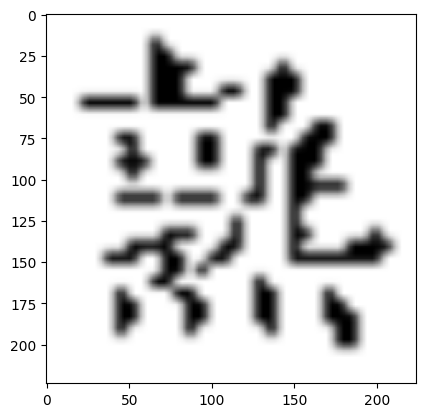

Label: 10


In [81]:
# plot a sample image
img, label = validset[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print("Label:", label)

### Weight Distribute

### DataLoader


In [66]:
# torch dataloader for model
batch_size = 64
train_loader = DataLoader(trainset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

# Model

### Model Architecture

### Initiate Model

Note: Change the input data transform fuction accordingly to the chosen model


In [67]:
#Choosing a pre-trained model from timm library (Change if needed)
model_link = 'efficientnet_b1_pruned'
model_name = model_link.split('.')[0]
print(model_name)
model = timm.create_model(model_link, pretrained=True, in_chans = 3, num_classes = num_classes)

efficientnet_b1_pruned


In [68]:
#Dowload model existing weight checkpoint (Change if needed)
model_weight_link = 'https://drive.google.com/file/d/10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL/view?usp=sharing'
!gdown 10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL

Downloading...
From (original): https://drive.google.com/uc?id=10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL
From (redirected): https://drive.google.com/uc?id=10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL&confirm=t&uuid=d9f64935-1363-46d0-aa85-c77feab77b8a
To: /content/Efficientnet_b1_09238_25epochs.pth
100% 94.1M/94.1M [00:00<00:00, 205MB/s]


In [69]:
# Init the checkpoint path (Change if needed)
checkpoint_path = f'/content/Efficientnet_b1_09238_25epochs.pth'

In [70]:
current_epoch = 0

if (os.path.isfile(checkpoint_path)):
    loaded_checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(loaded_checkpoint['model_state'])
    current_epoch = loaded_checkpoint['epochs'] + current_epoch
    print(f'Load model from checkpoint| Epoch: {current_epoch}')

Load model from checkpoint| Epoch: 25


In [71]:
model.to(device);

# Traning



### Parameter

In [72]:
leaning_rate = 1e-3 #0,001
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=leaning_rate)

### Traning Loop

In [73]:
def train(epoch):
    step_loss = []
    model.train()
    correct = 0

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        step_loss.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    accuracy = correct / len(train_loader.dataset)

    print(f"Epoch: {epoch}, Loss: {loss.item()}, Acc: {accuracy}" )

    return step_loss

In [74]:
def valid():
    step_loss = []
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss += criterion(output, y).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            step_loss.append(criterion(output, y).item())

    loss /= len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)

    return loss, accuracy, step_loss

In [ ]:
epochs = 5
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(epochs):
    train_loss = train(epoch)
    trainingEpoch_loss.append(np.array(train_loss).mean())

    loss, accuracy, val_loss = valid()
    print(loss, accuracy)
    validationEpoch_loss.append(np.array(val_loss).mean())

In [80]:
checkpoint = {
    "epochs": current_epoch + epochs,
    "model_state": model.state_dict(),
}

torch.save(checkpoint, checkpoint_path)

In [78]:
print(valid())

100%|██████████| 22/22 [00:05<00:00,  4.19it/s]

(0.009121993264911333, 0.9066091954022989, [0.5281130075454712, 0.05912097170948982, 1.2032406330108643, 0.6034275889396667, 0.10435862094163895, 0.5061490535736084, 0.26238253712654114, 0.49075156450271606, 0.3632667660713196, 0.487182080745697, 0.47903376817703247, 0.8901767134666443, 0.21381549537181854, 0.6390810012817383, 0.31297028064727783, 0.5097583532333374, 0.8129512667655945, 0.8336291909217834, 0.5626551508903503, 0.8330584764480591, 1.1305164098739624, 0.8721756935119629])


### Analyze
1 graph -> Epoch | Loss

In [ ]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.title("Loss curve")
plt.legend()
plt.show